In [8]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize,minimize_scalar
# constant variable definition 
beta = 1/(1+0.02)

# States of the economy, GOOD or BAD, {1 : GOOD}, {0 : BAD}
S = [0,1]
# current risk free interest rate 
r_f = [0.01 ,0.03]
# All the money amount are denoted in thousand dollars
earningShock = [0.9,1.1]
# Define transition matrix of economical states
# GOOD -> GOOD 0.8, BAD -> BAD 0.6 
P = np.array([[0.6, 0.4],[0.2, 0.8]])
# time line
T_min = 20
T_max = 80
T_y = 65
T = T_max - T_min
# All the money amount are denoted in thousand dollars
earningShock = [0.9,1.1]
# Define earning profile 
start = 4
high = 12
retire = 4
y = np.append(np.linspace(4,12,T_y - T_min), np.linspace(12,4,T_max - T_y + 1)[1:])

# Define the utility function 
def u(c):
    return np.log(c)

def chi(age, s):
    start = 4
    high = 12
    retire = 4
    y = np.append(np.linspace(4,12,T_y - T_min), np.linspace(12,4,T_max - T_y + 1)[1:])
    return y[age-T_min-1]*earningShock[int(s)]

# Define the transition of state 
def transition(Z, a):
    '''
        Input: Z is a tuple containing states variables: (w, s) which is the current wealth and econ state
               a is the action taken with contains variables: (c, b) which is the combination of consumption, bond and stock
        Output: the next possible states with corresponding probabilities
    '''
    w, s = Z
    c, b = a
    # collect possible next state (w_next, s_next) with probability prob
    Z_next = []
    prob = []
    # depend on the current econ state s and future state s_next we have the following return on bond and stock 
    for s_next in S:
        r_bond = r_f[int(s)]
        w_next = b*(1+r_bond)
        Z_next.append([w_next, s_next])
        prob.append(P[int(s), s_next])
    return np.array(Z_next), np.array(prob)

# Definition of the value function, return of the funciton is the value of the function and the coresponding policy
def V(w, s, t, model): 
    def obj(c):
        b = chi(t,s) + w - c
        if c <= 0 or b <= 0:
            return 9999999999
        else:
            Z_next, prob = transition([w , s], (c, b))
            V_next = np.array([model[int(z[1])](z[0]) for z in Z_next])
            return -(u(c) + beta * np.dot(V_next, prob))
    res = minimize_scalar(obj)
    return [-res.fun, res.x, chi(t,s) + w-res.x]

In [9]:
# Define the grid of wealth
Nw = 500; 
w_min =  0; 
w_max = 200;
wgrid = np.linspace(w_min,w_max, Nw)
# Place holder for value and policy 
b_T = np.zeros((Nw, 2));
c_T = np.zeros((Nw, 2));
c_T[:, 0] = wgrid + chi(T_max,0);
c_T[:, 1] = wgrid + chi(T_max,1);
V_T = np.log(c_T);

V_t = np.zeros((Nw,len(S),T))
C_t = np.zeros((Nw,len(S),T))
B_t = np.zeros((Nw,len(S),T))

V_t[:,:,T-1] = V_T
C_t[:,:,T-1] = c_T
B_t[:,:,T-1] = b_T

In [10]:
# Set value to the grid by backward induction 
from scipy.interpolate import interp1d
from multiprocessing import Pool
from functools import partial 

pool = Pool()

for t in range(T_max-2, T_max-10, -1):
    print(t)
    tt = t-T_min
    cs = [interp1d(wgrid, V_t[:,:,tt+1][:,0], kind = "cubic", fill_value="extrapolate"),
          interp1d(wgrid, V_t[:,:,tt+1][:,1], kind = "cubic", fill_value="extrapolate")] 
    for s in S:
        f = partial(V, s = s, t = t, model = cs)
        results = np.array(pool.map(f, wgrid))
        V_t[:,:,tt][:,s] = results[:,0]
        C_t[:,:,tt][:,s] = results[:,1]
        B_t[:,:,tt][:,s] = results[:,2]
pool.close()

78
77
76
75
74
73
72
71


Populating the interactive namespace from numpy and matplotlib


/home/hfsluser/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['beta', 'f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


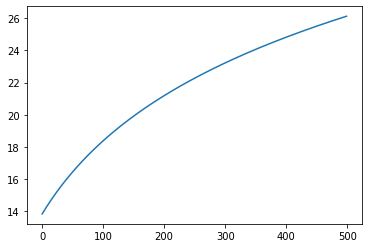

In [11]:
%pylab inline
plt.plot(cs[0](wgrid))

Populating the interactive namespace from numpy and matplotlib


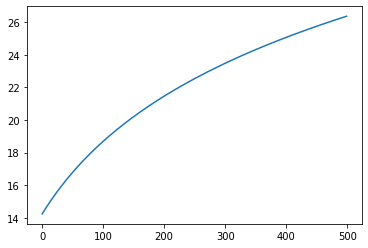

In [12]:
%pylab inline
plt.plot(cs[1](wgrid))

In [1]:
import numpy as np
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit([[7, 2, 3], [4, np.nan, 6], [10, 5, 9]])

X = [[np.nan, 2, 3], [4, np.nan, 6], [10, np.nan, 9]]
print(imp_mean.transform(X))

[[ 7.   2.   3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]


In [9]:
X[0][1] = X[0][0]

In [10]:
X

[[nan, nan, 3], [4, nan, 6], [10, nan, 9]]

In [11]:
print(imp_mean.transform(X))

[[ 7.   3.5  3. ]
 [ 4.   3.5  6. ]
 [10.   3.5  9. ]]
